In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20240316SATFB3236', '2024-Mar-16', '01:30:00', 'German Division 2 [GD2]', 'Paderborn', 'Braunschweig', 'true', '10.5', '1.86', '1.84', 'false', '11.5', '2.33', '1.53', 'false', '14.5', '4.60', '1.14']
['20240316SATFB3237', '2024-Mar-16', '01:30:00', 'German Division 2 [GD2]', 'Osnabruck', 'Dusseldorf', 'true', '10.5', '1.82', '1.88', 'false', '11.5', '2.29', '1.55', 'false', '14.5', '4.60', '1.14']
['20240316SATFB3240', '2024-Mar-16', '03:00:00', 'Dutch Division 1 [DFL]', 'Heracles', 'Go Ahead Eagles', 'true', '11.5', '2.22', '1.58', 'false', '12.5', '2.70', '1.39', 'false', '14.5', '4.40', '1.15']
['20240316SATFB3235', '2024-Mar-16', '03:30:00', 'German Division 1 [GSL]', 'Cologne', 'RB Leipzig', 'true', '10.5', '2.10', '1.65', 'false', '11.5', '2.60', '1.43', 'false', '13.5', '4.15', '1.17']
['20240316SATFB3245', '2024-Mar-16', '03:45:00', 'Italian Division 1 [ISA]', 'Empoli', 'Bologna', 'true', '9.5', '2.00', '1.72', 'false', '10.5', '2.55', '1.45', 'false', '13.5', '5.90', '1.08'

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = [o for o in odds if len(o) == 18]

In [13]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [14]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [15]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20240316SATFB3236,2024-Mar-16,01:30:00,German Division 2 [GD2],Paderborn,Braunschweig,true,10.5,1.86,1.84,false,11.5,2.33,1.53,false,14.5,4.60,1.14
1,20240316SATFB3237,2024-Mar-16,01:30:00,German Division 2 [GD2],Osnabruck,Dusseldorf,true,10.5,1.82,1.88,false,11.5,2.29,1.55,false,14.5,4.60,1.14
2,20240316SATFB3240,2024-Mar-16,03:00:00,Dutch Division 1 [DFL],Heracles,Go Ahead Eagles,true,11.5,2.22,1.58,false,12.5,2.70,1.39,false,14.5,4.40,1.15
3,20240316SATFB3235,2024-Mar-16,03:30:00,German Division 1 [GSL],Cologne,RB Leipzig,true,10.5,2.10,1.65,false,11.5,2.60,1.43,false,13.5,4.15,1.17
4,20240316SATFB3242,2024-Mar-16,04:00:00,Spanish Division 1 [SFL],Real Sociedad,Cadiz,true,9.5,2.07,1.67,false,10.5,2.65,1.41,false,12.5,4.40,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,20240318MONFB3289,2024-Mar-18,04:00:00,Spanish Division 1 [SFL],Atletico Madrid,Barcelona,true,10.5,2.20,1.59,false,11.5,2.75,1.38,false,13.5,4.60,1.14
101,20240318MONFB3437,2024-Mar-18,07:00:00,US Football League [MLS],Atlanta Utd,Orlando City,true,9.5,1.95,1.75,false,10.5,2.45,1.48,false,13.5,5.60,1.09
102,20240318MONFB3428,2024-Mar-18,08:00:00,Argentine Division 1 [APL],Estudiantes,Boca Juniors,true,8.5,1.93,1.77,false,11.5,4.40,1.15,false,9.5,2.55,1.45
103,20240319TUEFB3414,2024-Mar-19,03:30:00,Spanish Division 2 [SF2],FC Andorra,Amorebieta,true,8.5,1.80,1.90,false,12.5,5.15,1.11,false,9.5,2.25,1.57


In [16]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [17]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [18]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [19]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF', 'EFA', 'SFC']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [20]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [21]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [22]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [23]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [24]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [25]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [26]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [27]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [28]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [29]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [30]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [31]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [33]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [34]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB3236,SATFB3237,SATFB3273,SATFB3272,SATFB3270
Date,2024-03-16 00:00:00,2024-03-16 00:00:00,2024-03-16 00:00:00,2024-03-16 00:00:00,2024-03-16 00:00:00
Time,01:30:00,01:30:00,20:00:00,20:00:00,20:00:00
LeagueJC,German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2]
HomeTeamJC,Paderborn,Osnabruck,Nurnberg,Elversberg,Rostock
AwayTeamJC,Braunschweig,Dusseldorf,St. Pauli,Holstein Kiel,Greuther Furth
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,10.5,10.5,9.5,10.5,10.5
CHL_H_0,1.86,1.82,1.77,1.8,2.15
CHL_L_0,1.84,1.88,1.93,1.9,1.62


## Load model

In [35]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [36]:
to = load_pandas('models/to.pkl')

In [37]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [38]:
odds = odds.dropna(how='any')

In [39]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [40]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,D2,Paderborn,Braunschweig,16.6,7.0,11.8,4.6,12.2,9.8,9.2,14.0
1,D2,Osnabruck,Fortuna Dusseldorf,15.4,8.0,11.4,4.4,13.6,11.8,12.6,13.0
2,D2,Nurnberg,St Pauli,9.2,4.2,14.6,4.0,11.2,11.6,15.2,10.2
3,D2,Elversberg,Holstein Kiel,12.2,5.4,10.8,5.6,10.0,13.8,13.4,12.0
4,D2,Hansa Rostock,Greuther Furth,9.6,3.0,10.4,4.2,9.8,13.2,18.0,12.6
5,D2,Hannover,Kaiserslautern,18.0,6.8,15.2,5.0,14.8,14.6,11.4,7.6
6,D2,Hertha,Schalke 04,13.0,4.2,11.6,4.8,13.0,12.8,14.0,13.0
7,D2,Hamburg,Wehen,17.0,8.2,12.0,2.4,15.0,12.0,9.0,12.6
8,D2,Karlsruhe,Magdeburg,14.2,6.2,11.8,4.6,12.6,13.0,12.6,14.4
9,D1,FC Koln,RB Leipzig,12.0,7.0,13.2,4.0,9.4,12.4,12.8,13.0


In [41]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [42]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [43]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [44]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [45]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [46]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [47]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [48]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB3236,2024-03-16,01:30:00,German Division 2 [GD2],Paderborn,Braunschweig,True,10.5,1.86,1.84,0.060366,0.113963,5.787617,3.878373,-48.124168,-0.139845
1,SATFB3237,2024-03-16,01:30:00,German Division 2 [GD2],Osnabruck,Dusseldorf,True,10.5,1.82,1.88,0.059659,0.084073,5.853259,5.065205,-53.800705,-0.133656
2,SATFB3273,2024-03-16,20:00:00,German Division 2 [GD2],Nurnberg,St. Pauli,True,9.5,1.77,1.93,0.082074,0.081703,4.149133,5.346688,-48.973225,-0.139271
3,SATFB3272,2024-03-16,20:00:00,German Division 2 [GD2],Elversberg,Holstein Kiel,True,10.5,1.80,1.90,0.064193,0.077916,5.380590,4.977345,-52.003174,-0.124375
4,SATFB3270,2024-03-16,20:00:00,German Division 2 [GD2],Rostock,Greuther Furth,True,10.5,2.15,1.62,0.075800,0.089446,4.988151,4.868263,-49.518253,-0.146894


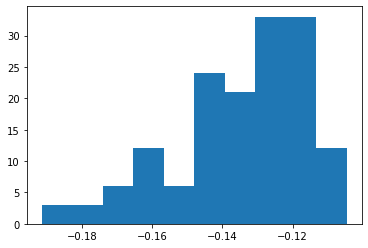

In [49]:
odds['corr'].hist(grid=False);

In [50]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [51]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [52]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [53]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [54]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [55]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [56]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [57]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [58]:
odds[odds.bet.notna() & odds.selected.notna()].reset_index(drop=True)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SATFB3261,2024-03-16,22:30:00,German Division 1 [GSL],Mainz,Bochum,True,10.5,2.15,1.62,0.255988,0.744012,0.331128,Low,$$
1,SUNFB3371,2024-03-17,22:30:00,German Division 1 [GSL],Freiburg,Leverkusen,True,10.5,2.25,1.57,0.252660,0.747340,0.304077,Low,$$
2,SUNFB3271,2024-03-17,03:30:00,German Division 2 [GD2],Hannover,Kaiserslautern,True,10.5,1.90,1.80,0.331769,0.668231,0.253521,Low,$$
3,SUNFB3287,2024-03-17,01:30:00,Spanish Division 1 [SFL],Getafe,Girona,True,8.5,1.83,1.87,0.347343,0.652657,0.253413,Low,$$
4,MONFB3418,2024-03-18,00:05:00,French Division 1 [FFL],Rennes,Marseille,True,9.5,1.95,1.75,0.347418,0.652582,0.189357,Low,$
5,SATFB3354,2024-03-16,23:00:00,Eng Championship [ED1],West Bromwich,Bristol City,True,10.5,2.07,1.67,0.579559,0.420441,0.186624,High,$
6,SUNFB3345,2024-03-17,23:30:00,FA Cup [EFA],Manchester Utd,Liverpool,True,11.5,1.92,1.78,0.358625,0.641375,0.181600,Low,$
7,SUNFB3290,2024-03-17,23:15:00,Spanish Division 1 [SFL],Las Palmas,Almeria,True,10.5,2.02,1.70,0.339189,0.660811,0.176255,Low,$
8,SATFB3236,2024-03-16,01:30:00,German Division 2 [GD2],Paderborn,Braunschweig,True,10.5,1.86,1.84,0.378010,0.621990,0.171978,Low,$
9,SATFB3283,2024-03-16,23:15:00,Spanish Division 1 [SFL],Osasuna,Real Madrid,True,9.5,2.05,1.68,0.340548,0.659452,0.158647,Low,$


In [59]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SUNFB3371,2024-03-17,22:30:00,German Division 1 [GSL],Freiburg,Leverkusen,False,13.5,4.60,1.14,0.069914,0.930086,0.430699,Low,None
1,SATFB3261,2024-03-16,22:30:00,German Division 1 [GSL],Mainz,Bochum,False,13.5,4.60,1.14,0.070453,0.929547,0.426315,Low,None
2,SUNFB3271,2024-03-17,03:30:00,German Division 2 [GD2],Hannover,Kaiserslautern,False,14.5,4.75,1.13,0.067712,0.932288,0.411422,Low,None
3,SUNFB3287,2024-03-17,01:30:00,Spanish Division 1 [SFL],Getafe,Girona,False,11.5,3.90,1.20,0.098994,0.901006,0.406035,Low,None
4,SATFB3261,2024-03-16,22:30:00,German Division 1 [GSL],Mainz,Bochum,False,11.5,2.70,1.39,0.174365,0.825635,0.378546,Low,None
5,SUNFB3371,2024-03-17,22:30:00,German Division 1 [GSL],Freiburg,Leverkusen,False,11.5,2.80,1.37,0.172211,0.827789,0.362353,Low,None
6,SATFB3261,2024-03-16,22:30:00,German Division 1 [GSL],Mainz,Bochum,True,10.5,2.15,1.62,0.255988,0.744012,0.331128,Low,$$
7,SUNFB3287,2024-03-17,01:30:00,Spanish Division 1 [SFL],Getafe,Girona,False,9.5,2.30,1.54,0.241048,0.758952,0.312567,Low,None
8,SUNFB3371,2024-03-17,22:30:00,German Division 1 [GSL],Freiburg,Leverkusen,True,10.5,2.25,1.57,0.252660,0.747340,0.304077,Low,$$
9,SATFB3236,2024-03-16,01:30:00,German Division 2 [GD2],Paderborn,Braunschweig,False,14.5,4.60,1.14,0.085959,0.914041,0.300045,Low,None


In [60]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)